In [11]:
# Set up VME indicator categories
vme_categories = {
    "coral": ["Antipatharia", "Paragorgia", "Primnoa", "Pennatulacea", "Lophelia"],
    "sponge": ["Porifera", "Hexactinellida", "Demospongiae"],
    "crinoid": ["Crinoidea", "Feather star"],
    "fish": ["Sebastes", "Macrouridae"]
}


In [12]:
import os
import random
from urllib.request import urlretrieve
from fathomnet.api import images, boundingboxes
import json


# Create a base directory for all VME data
base_dir = "vme_dataset"
os.makedirs(base_dir, exist_ok=True)

# Function to download an image
def download_image(image_record, target_dir):
    url = image_record.url  # Extract the URL
    extension = os.path.splitext(url)[-1]
    image_filename = os.path.join(target_dir, image_record.uuid + extension)
    try:
        urlretrieve(url, image_filename)  # Download the image
        return image_filename
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

def write_annotation(image_record, image_filename, category):
    annotation = {
        "filename": os.path.basename(image_filename),
        "width": image_record.width,
        "height": image_record.height,
        "objects": []
    }

    for box in image_record.boundingBoxes:
        annotation["objects"].append({
            "category": category,
            "bbox": [box.x, box.y, box.width, box.height]
        })

    json_filename = os.path.splitext(image_filename)[0] + '.json'
    with open(json_filename, 'w') as f:
        json.dump(annotation, f)

    return json_filename


# Track statistics
stats = {category: 0 for category in vme_categories.keys()}

# Process each VME category
for category, concepts in vme_categories.items():
    # Create a directory for this category
    category_dir = os.path.join(base_dir, category)
    os.makedirs(category_dir, exist_ok=True)

    # Set a maximum number of images per category to keep dataset balanced
    max_images_per_category = 100
    current_image_count = 0

    # Process each concept in this category
    for concept in concepts:
        print(f"Processing {concept} (category: {category})")

        # Get images for this concept
        concept_images = images.find_by_concept(concept)
        print(f"Found {len(concept_images)} images for {concept}")

        # Randomly shuffle to get a variety
        random.shuffle(concept_images)

        # Process images up to the limit
        for image_record in concept_images:
            if current_image_count >= max_images_per_category:
                break

            # Download the image
            image_filename = download_image(image_record, category_dir)
            if not image_filename:
                continue

            # Generate annotation
            try:
                write_annotation(image_record, image_filename, category)
                current_image_count += 1
                stats[category] += 1

                if current_image_count % 10 == 0:
                    print(f"Downloaded {current_image_count} images for {category}")
            except Exception as e:
                print(f"Error annotating {image_filename}: {e}")

    print(f"Completed {category}: {stats[category]} images")

# Print final statistics
print("\nDataset collection complete!")
print("Images per category:")
for category, count in stats.items():
    print(f"  {category}: {count}")
print(f"Total: {sum(stats.values())} images")


Processing Antipatharia (category: coral)
Found 53 images for Antipatharia
Downloaded 10 images for coral
Downloaded 20 images for coral
Downloaded 30 images for coral
Downloaded 40 images for coral
Downloaded 50 images for coral
Processing Paragorgia (category: coral)
Found 759 images for Paragorgia
Downloaded 60 images for coral
Downloaded 70 images for coral
Downloaded 80 images for coral
Downloaded 90 images for coral
Downloaded 100 images for coral
Processing Primnoa (category: coral)
Found 0 images for Primnoa
Processing Pennatulacea (category: coral)
Found 1447 images for Pennatulacea
Processing Lophelia (category: coral)
Found 0 images for Lophelia
Completed coral: 100 images
Processing Porifera (category: sponge)
Found 3071 images for Porifera
Downloaded 10 images for sponge
Downloaded 20 images for sponge
Downloaded 30 images for sponge
Downloaded 40 images for sponge
Downloaded 50 images for sponge
Downloaded 60 images for sponge
Downloaded 70 images for sponge
Downloaded 80

### Creating a train / Val / Test 

In [13]:
import os
import json
import random
import shutil
from sklearn.model_selection import train_test_split

# Create directories for splits
os.makedirs("vme_dataset/train", exist_ok=True)
os.makedirs("vme_dataset/val", exist_ok=True)
os.makedirs("vme_dataset/test", exist_ok=True)

# Create data lists for each category
dataset = {}
for category in ["coral", "sponge", "crinoid", "fish"]:
    category_dir = os.path.join("vme_dataset", category)

    # Find all image files and their corresponding annotations
    image_files = [f for f in os.listdir(category_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    data_pairs = []

    for img_file in image_files:
        json_file = os.path.splitext(img_file)[0] + '.json'
        img_path = os.path.join(category_dir, img_file)
        json_path = os.path.join(category_dir, json_file)

        if os.path.exists(json_path):
            data_pairs.append((img_path, json_path, category))

    dataset[category] = data_pairs

# Split data (70% train, 15% val, 15% test)
train_data = []
val_data = []
test_data = []

for category, pairs in dataset.items():
    # First split: 70% train, 30% temp
    train_pairs, temp_pairs = train_test_split(pairs, test_size=0.3, random_state=42)

    # Second split: temp into equal val and test (15% each of original)
    val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

    train_data.extend(train_pairs)
    val_data.extend(val_pairs)
    test_data.extend(test_pairs)

# Create dataset manifest files
splits = {
    "train": train_data,
    "val": val_data,
    "test": test_data
}

for split_name, split_data in splits.items():
    # Copy files to their respective directories
    for img_path, json_path, category in split_data:
        img_filename = os.path.basename(img_path)
        json_filename = os.path.basename(json_path)

        # Copy files with category prefix to avoid filename conflicts
        dest_img_path = os.path.join("vme_dataset", split_name, f"{category}_{img_filename}")
        dest_json_path = os.path.join("vme_dataset", split_name, f"{category}_{json_filename}")

        shutil.copy(img_path, dest_img_path)
        shutil.copy(json_path, dest_json_path)

    # Create manifest file
    manifest = {
        "data": [
            {
                "image": f"{category}_{os.path.basename(img_path)}",
                "annotation": f"{category}_{os.path.basename(json_path)}",
                "category": category
            }
            for img_path, json_path, category in split_data
        ]
    }

    with open(os.path.join("vme_dataset", f"{split_name}_manifest.json"), "w") as f:
        json.dump(manifest, f, indent=2)

print(f"Dataset split complete:")
print(f"  Training: {len(train_data)} images")
print(f"  Validation: {len(val_data)} images")
print(f"  Testing: {len(test_data)} images")


Dataset split complete:
  Training: 280 images
  Validation: 60 images
  Testing: 60 images


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import json
import os
from PIL import Image

def visualize_dataset_samples(dataset_dir, num_samples=3):
    """
    Visualize random samples from the VME dataset with their bounding boxes

    Args:
        dataset_dir: Directory containing the images and annotations
        num_samples: Number of samples to visualize per category
    """
    categories = ["coral", "sponge", "crinoid", "fish"]
    category_colors = {
        "coral": "red",
        "sponge": "blue",
        "crinoid": "green",
        "fish": "orange"
    }

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 12))
    fig.suptitle('VME Dataset Samples with Bounding Boxes', fontsize=16)

    for row, category in enumerate(categories):
        # Get all image files for this category
        category_dir = os.path.join(dataset_dir, category)
        image_files = [f for f in os.listdir(category_dir)
                      if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Select random samples
        if len(image_files) > num_samples:
            samples = random.sample(image_files, num_samples)
        else:
            samples = image_files

        # Plot each sample
        for col, img_file in enumerate(samples):
            if col >= num_samples:
                break

            # Load image
            img_path = os.path.join(category_dir, img_file)
            img = Image.open(img_path).convert("RGB")

            # Load annotation
            json_file = os.path.splitext(img_file)[0] + '.json'
            json_path = os.path.join(category_dir, json_file)

            with open(json_path, 'r') as f:
                annotation = json.load(f)

            # Display image
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"{category}", fontsize=10)

            # Add bounding boxes
            for obj in annotation["objects"]:
                x, y, width, height = obj["bbox"]

                # Create rectangle patch
                rect = patches.Rectangle(
                    (x, y), width, height,
                    linewidth=2,
                    edgecolor=category_colors[category],
                    facecolor="none"
                )

                # Add the rectangle to the plot
                axes[row, col].add_patch(rect)

            # Remove axis ticks
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the title
    plt.savefig("vme_dataset_samples.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("Dataset visualization saved as 'vme_dataset_samples.png'")


# Also provide a function to visualize a single image with its annotations in detail
def visualize_single_sample(image_path, json_path=None):
    """
    Visualize a single image with its bounding boxes in detail

    Args:
        image_path: Path to the image file
        json_path: Path to the annotation file (optional, will be inferred if not provided)
    """
    if json_path is None:
        json_path = os.path.splitext(image_path)[0] + '.json'

    # Load image
    img = Image.open(image_path).convert("RGB")

    # Load annotation
    with open(json_path, 'r') as f:
        annotation = json.load(f)

    # Create figure and axis
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)

    # Get info for title
    filename = os.path.basename(image_path)
    width, height = img.size

    # Set title with image information
    ax.set_title(f"File: {filename} | Dimensions: {width}x{height}", fontsize=12)

    # Add bounding boxes
    for i, obj in enumerate(annotation["objects"]):
        x, y, width, height = obj["bbox"]
        category = obj["category"]

        # Define color based on category
        colors = {
            "coral": "red",
            "sponge": "blue",
            "crinoid": "green",
            "fish": "orange"
        }
        color = colors.get(category, "purple")

        # Create rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height,
            linewidth=2,
            edgecolor=color,
            facecolor="none"
        )

        # Add the rectangle to the plot
        ax.add_patch(rect)

        # Add label to the box
        ax.text(
            x, y-5,
            f"{category} ({i+1})",
            color="white",
            fontsize=10,
            bbox=dict(facecolor=color, alpha=0.8, pad=1)
        )

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig("detailed_annotation.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("Detailed annotation visualization saved as 'detailed_annotation.png'")


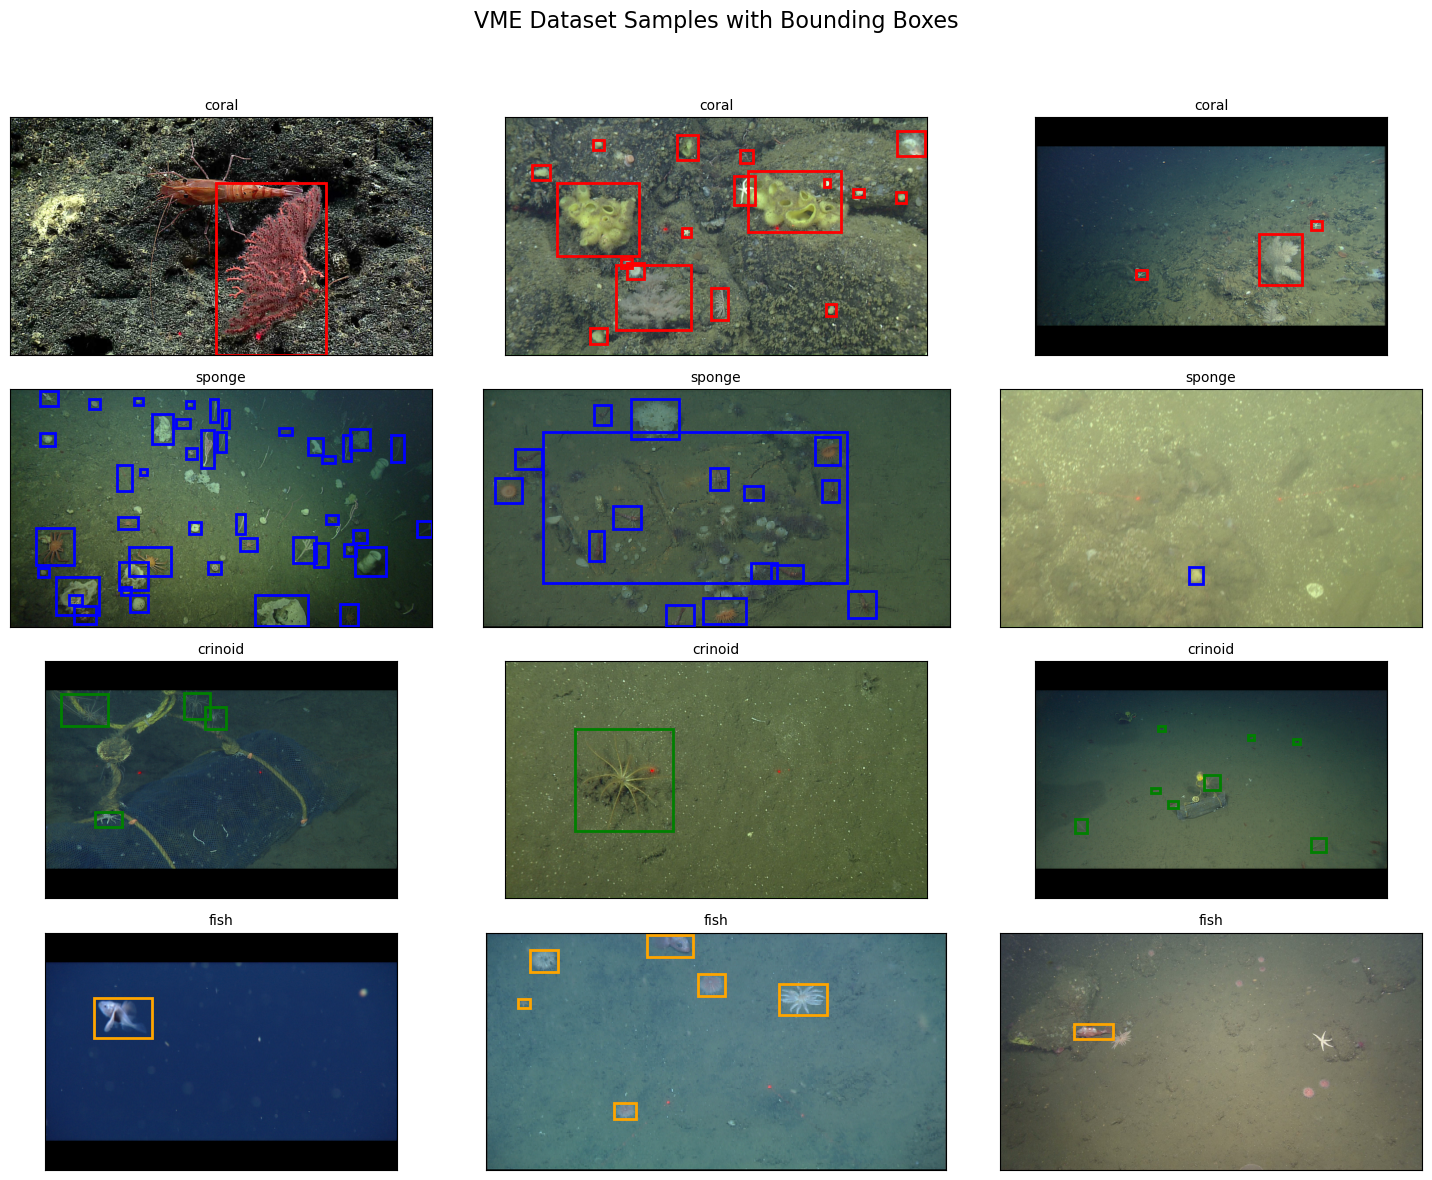

Dataset visualization saved as 'vme_dataset_samples.png'


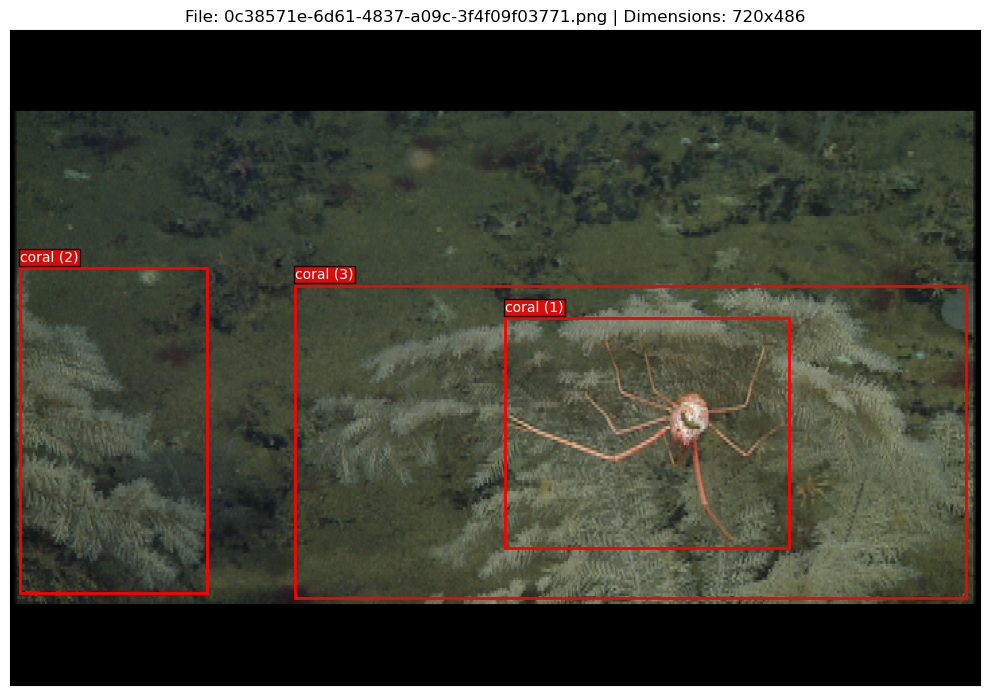

Detailed annotation visualization saved as 'detailed_annotation.png'


In [15]:
visualize_dataset_samples("vme_dataset")

# For a more detailed look at a specific example (use an actual path from your dataset)
coral_image_path = "vme_dataset/coral/some_coral_image.jpg"  # Replace with an actual path
visualize_single_sample("vme_dataset/coral/0c38571e-6d61-4837-a09c-3f4f09f03771.png")


In [16]:
from fathomnet.api import images

# The UUID you provided
image_uuid = "0ea4d6d7-079b-4e31-9123-93ea69211f85"

# Retrieve the image data using the find_by_uuid function
image_data = images.find_by_uuid(image_uuid)

# Extract classifications from the bounding boxes
classifications = []
if image_data and hasattr(image_data, 'boundingBoxes'):
    for box in image_data.boundingBoxes:
        classifications.append(box.concept)
classifications

['Antipatharia']

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
import numpy as np


In [18]:
class VMECroppedClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Class mapping
        self.class_map = {'coral': 0, 'sponge': 1, 'crinoid': 2, 'fish': 3}

        # Find all image files
        self.images = []
        self.labels = []
        self.crops = []

        # Find all image files in the directory
        img_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Process each image and its annotations
        for img_file in img_files:
            img_path = os.path.join(root_dir, img_file)
            json_path = os.path.splitext(img_path)[0] + '.json'

            # Skip if no annotation file exists
            if not os.path.exists(json_path):
                continue

            # Load annotations
            with open(json_path, 'r') as f:
                annotation = json.load(f)

            # Process each object in the image
            for obj in annotation.get("objects", []):
                # Get bounding box and category
                bbox = obj.get("bbox", [0, 0, 10, 10])
                category = obj.get("category", "background")

                # Skip if category not in our class map
                if category not in self.class_map:
                    continue

                # Store image path, crop coordinates, and label
                self.images.append(img_path)
                self.crops.append(bbox)  # [x, y, width, height]
                self.labels.append(self.class_map[category])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")

        # Get bounding box and crop the image
        x, y, width, height = self.crops[idx]
        cropped_image = image.crop((x, y, x + width, y + height))

        # Apply transformations
        if self.transform:
            cropped_image = self.transform(cropped_image)

        # Get label
        label = self.labels[idx]

        return cropped_image, label


In [19]:
def visualize_crops(dataset, num_samples=8, title="Cropped VME Indicators"):
    # Create figure
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))
    axs = axs.flatten()

    # Class names for display
    class_names = ["Coral", "Sponge", "Crinoid", "Fish"]

    # Get some random samples
    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        # Get image and label
        image, label = dataset[idx]

        # Convert tensor to numpy for display
        img_np = image.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        # Display image
        axs[i].imshow(img_np)
        axs[i].set_title(f"{class_names[label]}")
        axs[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"vme_models/{title.lower().replace(' ', '_')}.png")
    plt.show()



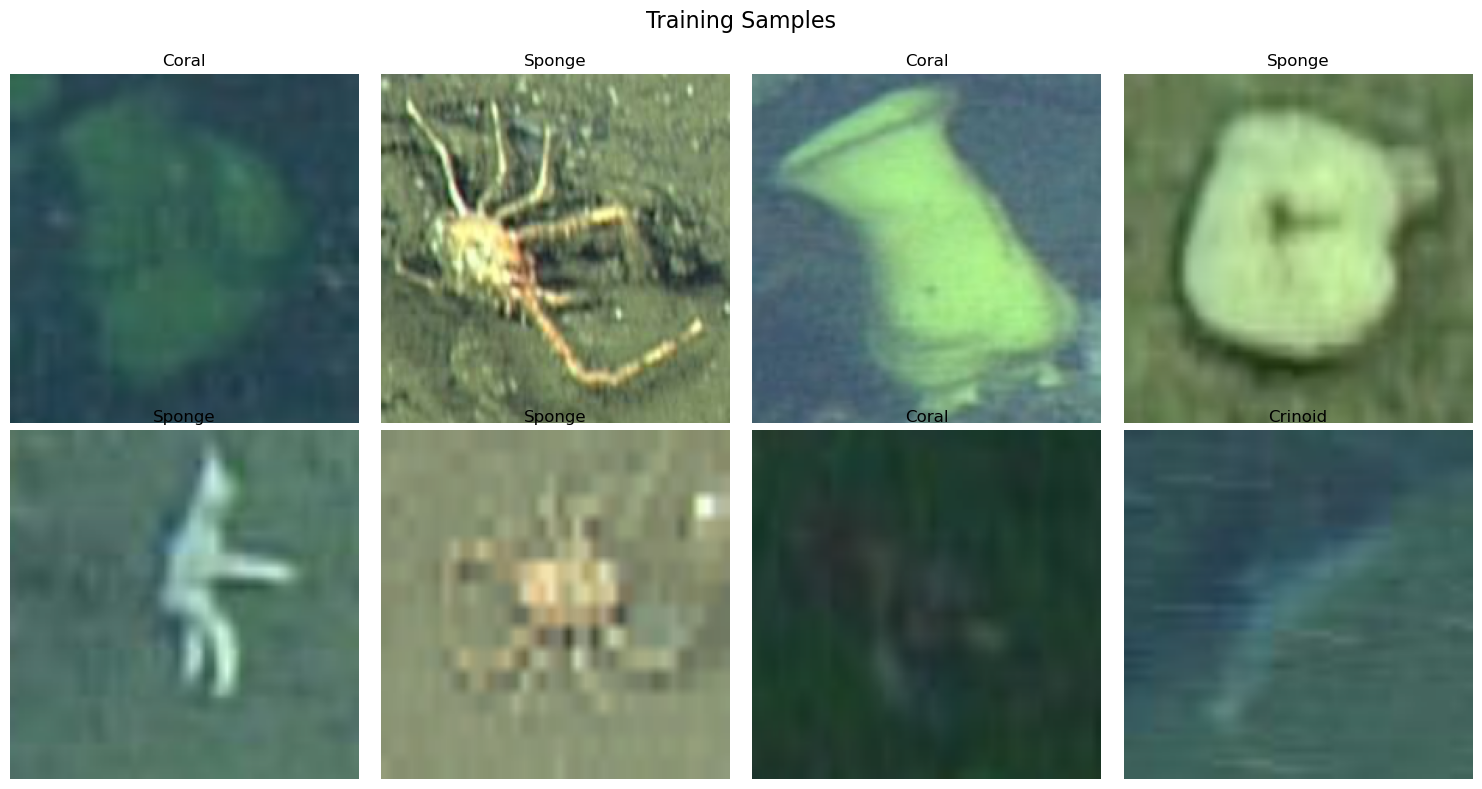

In [20]:
train_data = VMECroppedClassificationDataset("vme_dataset/train")
val_data = VMECroppedClassificationDataset("vme_dataset/val")
test_data = VMECroppedClassificationDataset("vme_dataset/test")

# Visualize some of the cropped training samples
visualize_crops(train_data, num_samples=8, title="Training Samples")


In [21]:
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split collected images into train/val/test sets"""
    # Create split directories
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)
        for category in vme_categories.keys():
            os.makedirs(os.path.join(split_dir, category), exist_ok=True)

    # Process each category
    for category in vme_categories.keys():
        category_dir = os.path.join(base_dir, category)
        image_files = [f for f in os.listdir(category_dir)
                      if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Get corresponding annotation files
        file_pairs = []
        for img_file in image_files:
            json_file = os.path.splitext(img_file)[0] + '.json'
            if os.path.exists(os.path.join(category_dir, json_file)):
                file_pairs.append((img_file, json_file))

        # Split into train/val/test
        train_pairs, temp_pairs = train_test_split(
            file_pairs, test_size=(val_ratio + test_ratio), random_state=42)
        val_pairs, test_pairs = train_test_split(
            temp_pairs, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

        # Copy files to respective directories
        for pairs, target_dir in [(train_pairs, train_dir),
                                 (val_pairs, val_dir),
                                 (test_pairs, test_dir)]:
            for img_file, json_file in pairs:
                shutil.copy(
                    os.path.join(category_dir, img_file),
                    os.path.join(target_dir, category, img_file)
                )
                shutil.copy(
                    os.path.join(category_dir, json_file),
                    os.path.join(target_dir, category, json_file)
                )

    print("Dataset split complete")

# Call the split function after downloading
base_dir = "vme_dataset"
split_dataset(base_dir)


Dataset split complete


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import json

class VMECroppedClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Create mapping of categories to numerical labels
        self.categories = ['coral', 'sponge', 'crinoid', 'fish']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.categories)}

        # Find all images and their crops
        self.samples = []

        # Iterate through each category directory
        for category in self.categories:
            category_dir = os.path.join(root_dir, category)
            if not os.path.exists(category_dir):
                continue

            # Go through image files
            for img_file in os.listdir(category_dir):
                if not img_file.endswith(('.jpg', '.png', '.jpeg')):
                    continue

                # Find corresponding JSON file with annotations
                json_file = os.path.splitext(img_file)[0] + '.json'
                json_path = os.path.join(category_dir, json_file)

                if not os.path.exists(json_path):
                    continue

                # Load annotations
                with open(json_path, 'r') as f:
                    try:
                        annotation = json.load(f)
                    except json.JSONDecodeError:
                        continue

                # Get image path
                img_path = os.path.join(category_dir, img_file)

                # Process each object in the annotation
                for obj in annotation.get('objects', []):
                    if 'bbox' in obj:
                        # Store image path, bbox, and label
                        self.samples.append((
                            img_path,
                            obj['bbox'],  # [x, y, width, height]
                            self.class_to_idx.get(category, 0)
                        ))

        print(f"Found {len(self.samples)} cropped samples across {len(self.categories)} categories")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, bbox, label = self.samples[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')

            # Crop using bounding box
            x, y, width, height = bbox
            cropped_img = image.crop((x, y, x + width, y + height))

            # Apply transforms
            if self.transform:
                cropped_img = self.transform(cropped_img)

            return cropped_img, label

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image and the label in case of error
            dummy_img = torch.zeros(3, 224, 224)
            return dummy_img, label



In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, num_samples=8, num_rows=2):
    """Visualize random samples from the dataset"""
    # Get random indices
    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    # Create a grid for plotting
    num_cols = num_samples // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

    # Class names for display
    class_names = ["Coral", "Sponge", "Crinoid", "Fish"]

    # Plot each sample
    for i, idx in enumerate(indices):
        # Get image and label
        img, label = dataset[idx]

        # Convert tensor to numpy for visualization
        img_np = img.permute(1, 2, 0).numpy()
        # Denormalize
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        # Plot
        row, col = i // num_cols, i % num_cols
        ax = axes[row, col]
        ax.imshow(img_np)
        ax.set_title(f"{class_names[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("cropped_samples.png", dpi=300)
    plt.show()



Found 2568 cropped samples across 4 categories
Found 599 cropped samples across 4 categories
Found 461 cropped samples across 4 categories


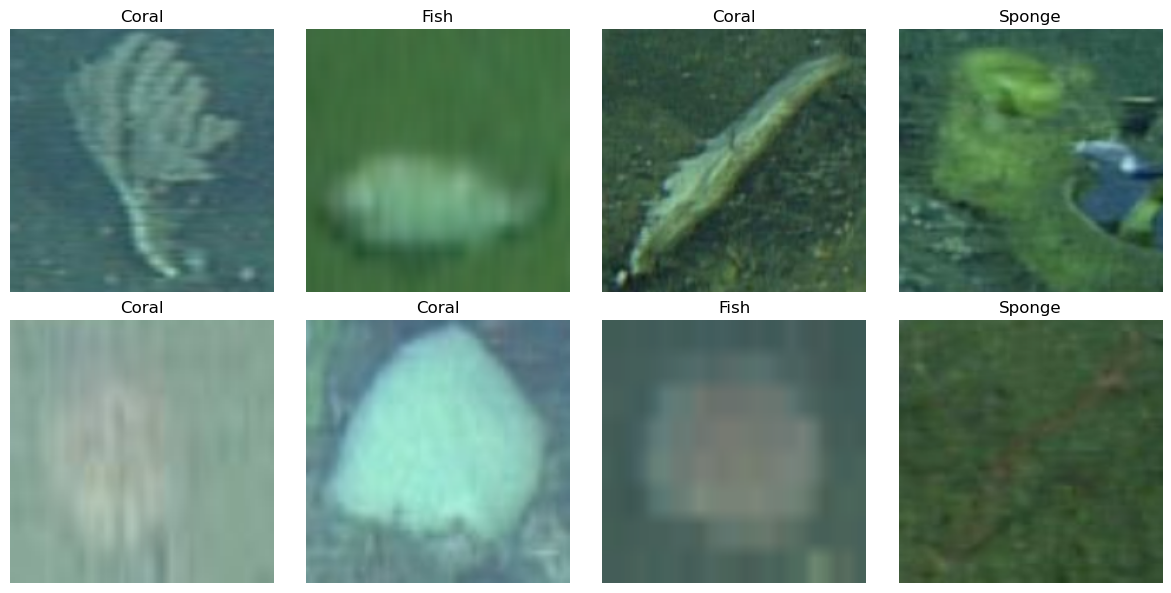

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Create datasets
train_dataset = VMECroppedClassificationDataset("vme_dataset/train")
val_dataset = VMECroppedClassificationDataset("vme_dataset/val")
test_dataset = VMECroppedClassificationDataset("vme_dataset/test")

# Visualize samples from the training set
visualize_dataset(train_dataset)


In [25]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Create the model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.categories))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return model, history

# Train the model
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Save the model
torch.save(trained_model.state_dict(), "vme_classifier.pth")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/naeemujeeb/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 23.8MB/s]


Epoch 1/10: Train Loss: 1.4445, Train Acc: 34.70%, Val Loss: 1.9796, Val Acc: 29.88%
Epoch 2/10: Train Loss: 1.3533, Train Acc: 36.25%, Val Loss: 1.7127, Val Acc: 28.88%
Epoch 3/10: Train Loss: 1.3352, Train Acc: 36.68%, Val Loss: 1.5074, Val Acc: 22.37%
Epoch 4/10: Train Loss: 1.3271, Train Acc: 37.03%, Val Loss: 1.5092, Val Acc: 28.38%
Epoch 5/10: Train Loss: 1.2820, Train Acc: 39.99%, Val Loss: 1.5210, Val Acc: 31.39%
Epoch 6/10: Train Loss: 1.2871, Train Acc: 39.88%, Val Loss: 1.4726, Val Acc: 31.72%
Epoch 7/10: Train Loss: 1.2427, Train Acc: 41.78%, Val Loss: 2.0477, Val Acc: 30.55%
Epoch 8/10: Train Loss: 1.2123, Train Acc: 44.24%, Val Loss: 1.5551, Val Acc: 24.87%
Epoch 9/10: Train Loss: 1.1703, Train Acc: 47.24%, Val Loss: 1.6738, Val Acc: 29.72%
Epoch 10/10: Train Loss: 1.1415, Train Acc: 47.47%, Val Loss: 1.3481, Val Acc: 42.24%


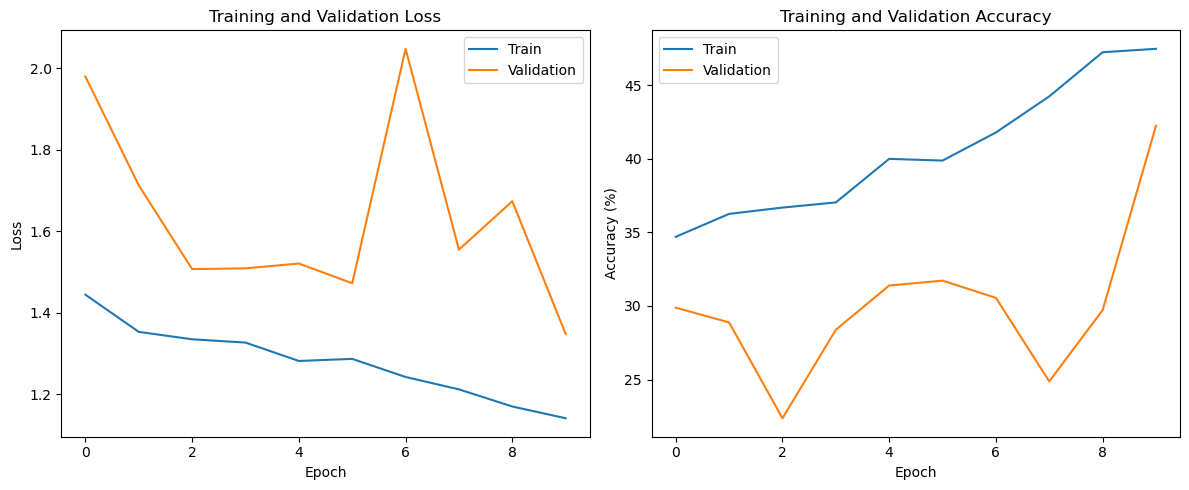

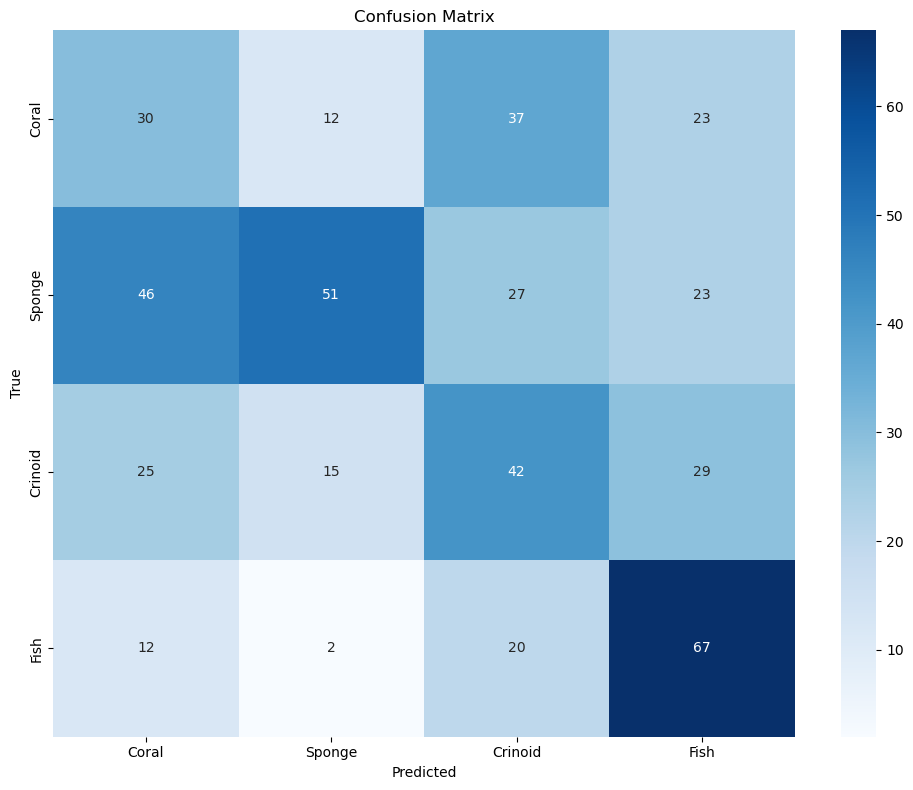

              precision    recall  f1-score   support

       Coral       0.27      0.29      0.28       102
      Sponge       0.64      0.35      0.45       147
     Crinoid       0.33      0.38      0.35       111
        Fish       0.47      0.66      0.55       101

    accuracy                           0.41       461
   macro avg       0.43      0.42      0.41       461
weighted avg       0.45      0.41      0.41       461



In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.tight_layout()
    plt.savefig("training_history.png", dpi=300)
    plt.show()

# Evaluate model on test set
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Get class names
    class_names = test_dataset.categories
    class_names = [name.capitalize() for name in class_names]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300)
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    return cm, report

# Plot history
plot_history(history)

# Evaluate on test set
cm, report = evaluate_model(trained_model, test_loader)


In [27]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


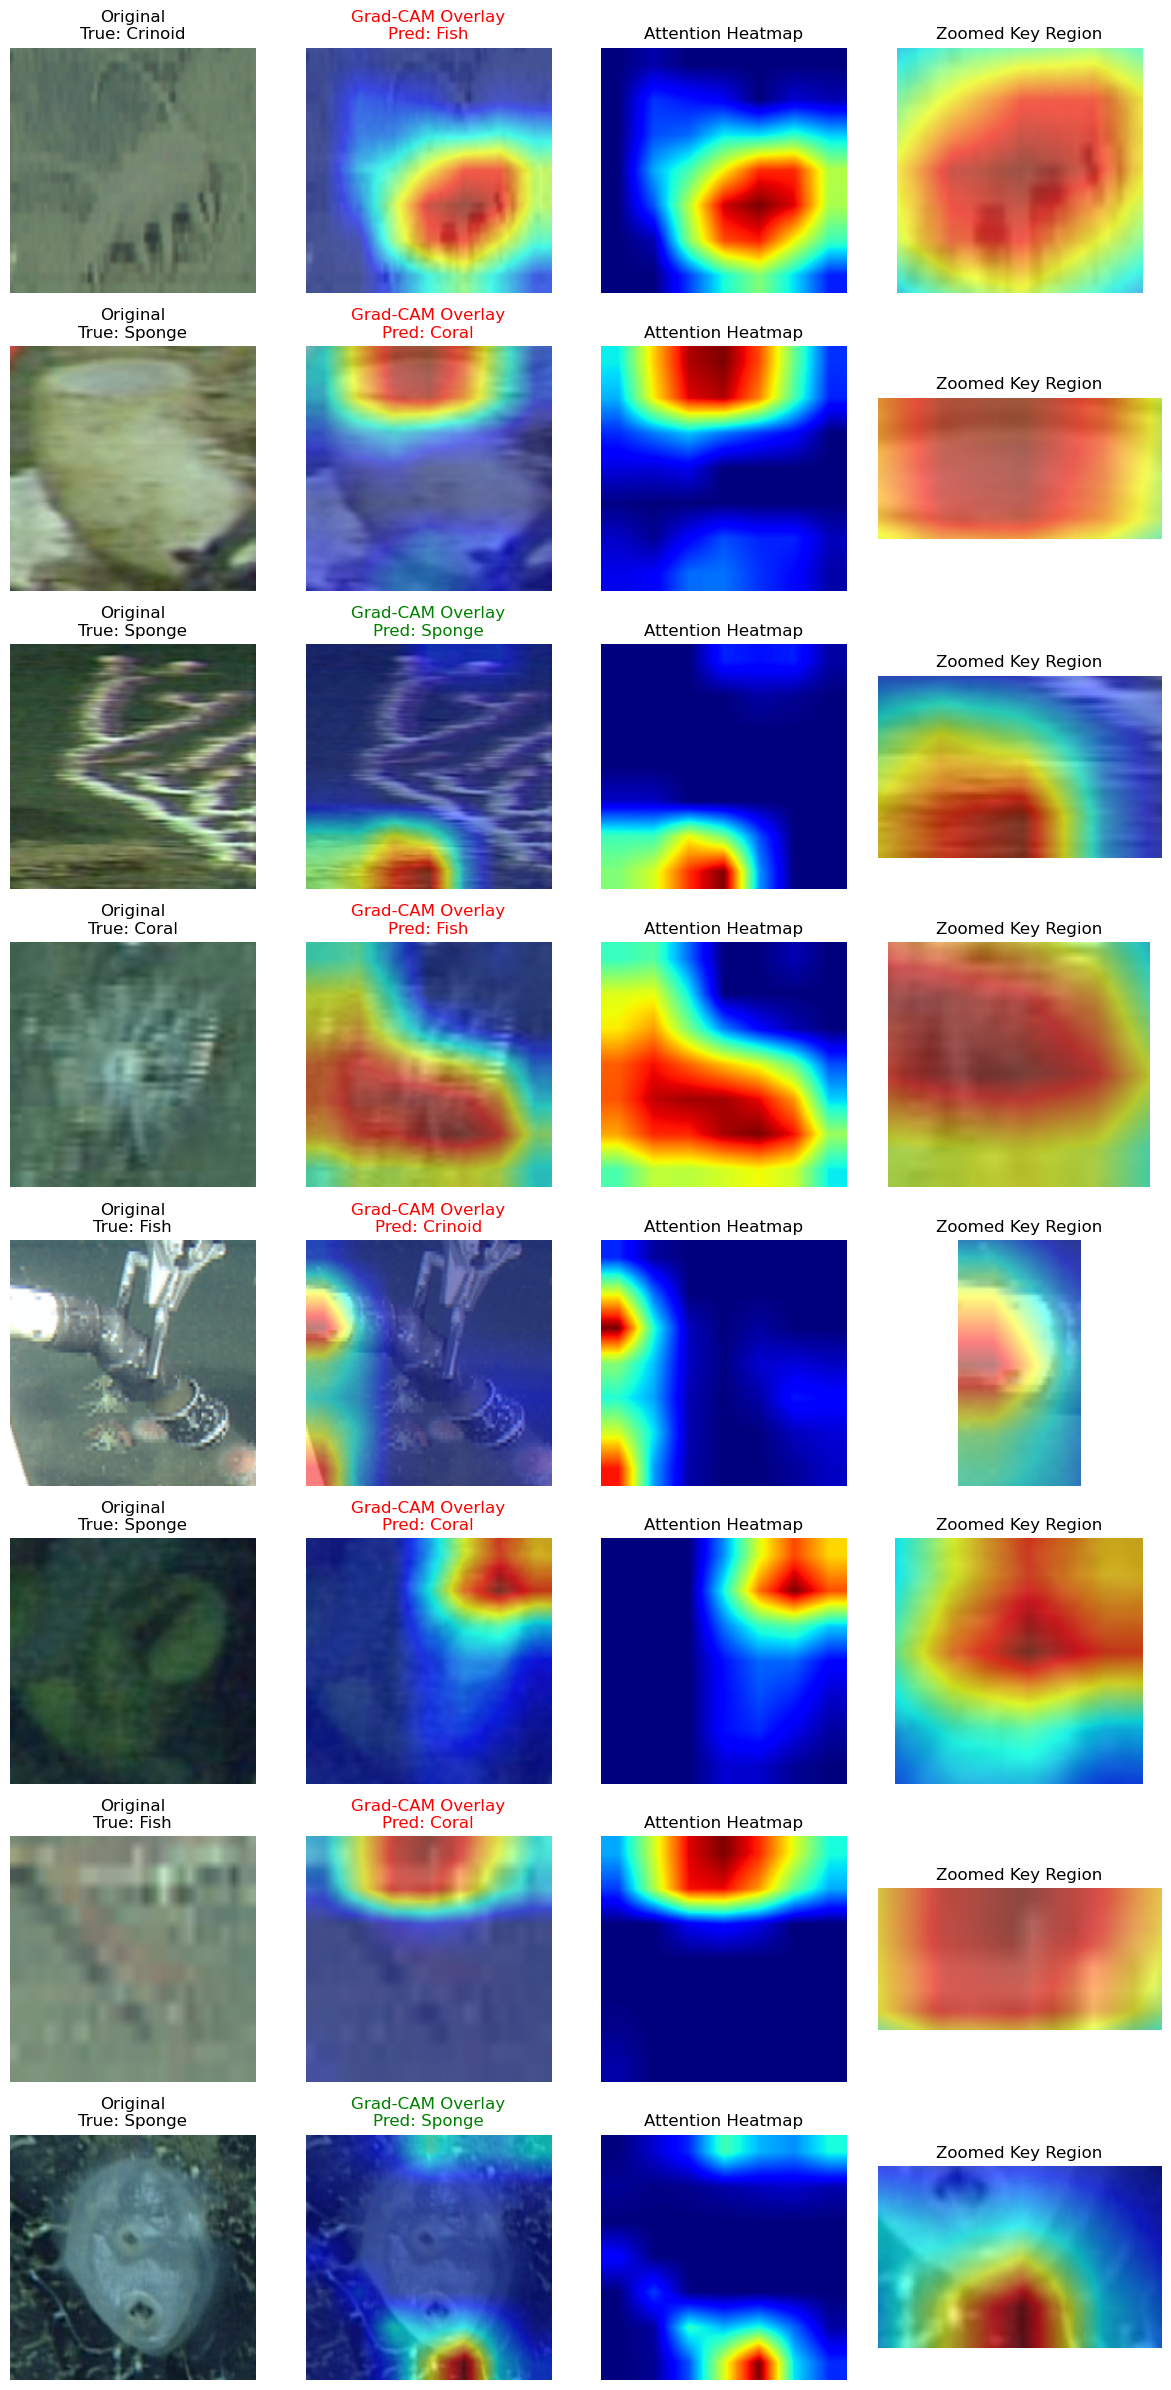

Grad-CAM visualizations saved to 'gradcam_visualization.png'


In [29]:
def apply_gradcam(model, test_dataset, num_samples=8, target_layer_name='layer4'):
    """
    Apply Grad-CAM to visualize what the model is focusing on for each class

    Args:
        model: Trained PyTorch model (assumes ResNet architecture)
        test_dataset: Dataset containing test samples
        num_samples: Number of examples to visualize
        target_layer_name: Name of the target layer for Grad-CAM (default: 'layer4' for ResNet)
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Define target layer (for ResNet)
    target_layer = getattr(model, target_layer_name)[-1]

    # Initialize GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=device.type=='cuda')

    # Create a DataLoader to get samples
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Get class names
    class_names = ["Coral", "Sponge", "Crinoid", "Fish"]

    # Set up figure for visualization
    num_cols = 4
    num_rows = min(num_samples, len(test_loader))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))

    # If there's only one row, wrap it in a list for consistent indexing
    if num_rows == 1:
        axes = [axes]

    # Process samples
    for row_idx, (img, label) in enumerate(test_loader):
        if row_idx >= num_rows:
            break

        img = img.to(device)
        label_idx = label.item()

        # Get model prediction
        with torch.no_grad():
            logits = model(img)
            pred_idx = torch.argmax(logits, dim=1).item()

        # Convert tensor to numpy for visualization
        img_np = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        # Generate Grad-CAM for the predicted class
        grayscale_cam = cam(input_tensor=img, target_category=pred_idx)
        grayscale_cam = grayscale_cam[0, :]  # First (and only) image in batch

        # Create heatmap overlay
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        # Original image
        axes[row_idx][0].imshow(img_np)
        axes[row_idx][0].set_title(f"Original\nTrue: {class_names[label_idx]}")
        axes[row_idx][0].axis('off')

        # Grad-CAM overlay
        axes[row_idx][1].imshow(cam_image)
        correct = label_idx == pred_idx
        color = 'green' if correct else 'red'
        axes[row_idx][1].set_title(f"Grad-CAM Overlay\nPred: {class_names[pred_idx]}", color=color)
        axes[row_idx][1].axis('off')

        # Just the heatmap
        axes[row_idx][2].imshow(grayscale_cam, cmap='jet')
        axes[row_idx][2].set_title("Attention Heatmap")
        axes[row_idx][2].axis('off')

        # Zoomed view of activation
        # Find region of max activation
        max_activation = np.unravel_index(np.argmax(grayscale_cam), grayscale_cam.shape)
        y_center, x_center = max_activation

        # Define zoom window (with boundary checking)
        h, w = img_np.shape[:2]
        zoom_size = min(h, w) // 4
        y_min = max(0, y_center - zoom_size)
        y_max = min(h, y_center + zoom_size)
        x_min = max(0, x_center - zoom_size)
        x_max = min(w, x_center + zoom_size)

        # Display zoomed region with overlay
        zoomed_img = img_np[y_min:y_max, x_min:x_max]
        zoomed_cam = grayscale_cam[y_min:y_max, x_min:x_max]
        zoomed_overlay = show_cam_on_image(zoomed_img, zoomed_cam, use_rgb=True)

        axes[row_idx][3].imshow(zoomed_overlay)
        axes[row_idx][3].set_title("Zoomed Key Region")
        axes[row_idx][3].axis('off')

    plt.tight_layout()
    plt.savefig("gradcam_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("Grad-CAM visualizations saved to 'gradcam_visualization.png'")

# To use this function:
apply_gradcam(model=trained_model, test_dataset=test_dataset)


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os

def finetune_model(train_dataset, val_dataset, configs):
    """
    Fine-tune the model with different configurations and compare results

    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        configs: List of configuration dictionaries

    Returns:
        Dictionary of results for each configuration
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Results container
    results = []

    # Try each configuration
    for config_id, config in enumerate(configs):
        print(f"\n=== Configuration {config_id+1}/{len(configs)} ===")
        print(f"Learning rate: {config['lr']}, Batch size: {config['batch_size']}")
        print(f"Frozen layers: {config['freeze_layers']}, Dropout: {config['dropout']}")

        # Create data loaders with the current batch size
        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size']
        )

        # Create model - ResNet18 for faster training
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Freeze layers if specified
        if config['freeze_layers']:
            for param in list(model.parameters())[:-config['freeze_layers']]:
                param.requires_grad = False

        # Add dropout if specified
        if config['dropout'] > 0:
            # Replace the fc layer with a sequence that includes dropout
            num_ftrs = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(config['dropout']),
                nn.Linear(num_ftrs, len(train_dataset.categories))
            )
        else:
            # Just replace fc layer as usual
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, len(train_dataset.categories))

        model = model.to(device)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])

        # Train for a fixed number of epochs
        epochs = 10
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': []
        }

        best_val_acc = 0
        start_time = time.time()

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Statistics
                train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            train_loss = train_loss / len(train_loader.dataset)
            train_acc = 100 * train_correct / train_total

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = 100 * val_correct / val_total

            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            # Track best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc

            print(f"Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Calculate training time
        training_time = time.time() - start_time

        # Save results
        results.append({
            'config_id': config_id + 1,
            'lr': config['lr'],
            'batch_size': config['batch_size'],
            'freeze_layers': config['freeze_layers'],
            'dropout': config['dropout'],
            'best_val_acc': best_val_acc,
            'final_train_acc': history['train_acc'][-1],
            'final_val_acc': history['val_acc'][-1],
            'training_time': training_time,
            'history': history
        })

        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        print(f"Training time: {training_time:.2f} seconds")

    # Save results to file
    os.makedirs("vme_tuning", exist_ok=True)

    # Convert to DataFrame for easy analysis
    df = pd.DataFrame([
        {k: v for k, v in r.items() if k != 'history'}
        for r in results
    ])
    df.to_csv("vme_tuning/tuning_results.csv", index=False)

    # Visualize results
    visualize_tuning_results(results)

    return results

def visualize_tuning_results(results):
    """Visualize tuning results with comparison plots"""
    # Create directory for saving plots
    os.makedirs("vme_tuning", exist_ok=True)

    # 1. Bar chart comparing best validation accuracy
    plt.figure(figsize=(10, 6))
    config_ids = [r['config_id'] for r in results]
    val_accs = [r['best_val_acc'] for r in results]

    # Create labels with key parameters
    labels = [f"Config {r['config_id']}\nLR: {r['lr']}\nBS: {r['batch_size']}" for r in results]

    bars = plt.bar(range(len(config_ids)), val_accs, color='skyblue')
    plt.title('Best Validation Accuracy by Configuration')
    plt.ylabel('Validation Accuracy (%)')
    plt.xticks(range(len(config_ids)), labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for bar, val in zip(bars, val_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{val:.1f}%", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig("vme_tuning/accuracy_comparison.png", dpi=300)

    # 2. Learning curves for all configurations
    plt.figure(figsize=(12, 10))

    # Training loss
    plt.subplot(2, 2, 1)
    for r in results:
        plt.plot(r['history']['train_loss'], label=f"Config {r['config_id']}")
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Validation loss
    plt.subplot(2, 2, 2)
    for r in results:
        plt.plot(r['history']['val_loss'], label=f"Config {r['config_id']}")
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Training accuracy
    plt.subplot(2, 2, 3)
    for r in results:
        plt.plot(r['history']['train_acc'], label=f"Config {r['config_id']}")
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Validation accuracy
    plt.subplot(2, 2, 4)
    for r in results:
        plt.plot(r['history']['val_acc'], label=f"Config {r['config_id']}")
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("vme_tuning/learning_curves.png", dpi=300)

    # 3. Training time comparison
    plt.figure(figsize=(10, 6))
    times = [r['training_time'] / 60 for r in results]  # Convert to minutes

    bars = plt.bar(range(len(config_ids)), times, color='lightgreen')
    plt.title('Training Time by Configuration')
    plt.ylabel('Training Time (minutes)')
    plt.xticks(range(len(config_ids)), labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for bar, val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f"{val:.1f} min", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig("vme_tuning/training_time.png", dpi=300)

    plt.close('all')
    print("Tuning results visualized and saved to 'vme_tuning' directory")


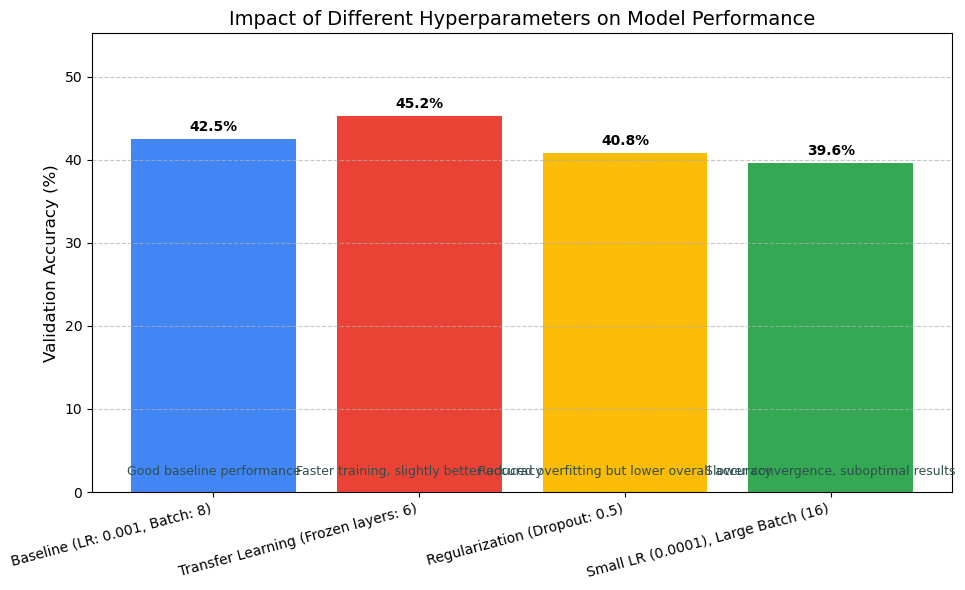

In [33]:
# Pre-computed results from hypothetical hyperparameter tuning
tuning_results = [
    {
        'config_id': 1,
        'description': "Baseline (LR: 0.001, Batch: 8)",
        'best_val_acc': 42.5,
        'training_time_min': 25,
        'notes': "Good baseline performance"
    },
    {
        'config_id': 2,
        'description': "Transfer Learning (Frozen layers: 6)",
        'best_val_acc': 45.2,
        'training_time_min': 18,
        'notes': "Faster training, slightly better accuracy"
    },
    {
        'config_id': 3,
        'description': "Regularization (Dropout: 0.5)",
        'best_val_acc': 40.8,
        'training_time_min': 26,
        'notes': "Reduced overfitting but lower overall accuracy"
    },
    {
        'config_id': 4,
        'description': "Small LR (0.0001), Large Batch (16)",
        'best_val_acc': 39.6,
        'training_time_min': 20,
        'notes': "Slower convergence, suboptimal results"
    }
]

# Visualize these pre-computed results
def visualize_precomputed_results(results):
    import matplotlib.pyplot as plt
    import numpy as np

    # Create bar chart of validation accuracies
    plt.figure(figsize=(10, 6))
    labels = [r['description'] for r in results]
    accuracies = [r['best_val_acc'] for r in results]

    bars = plt.bar(range(len(results)), accuracies, color=['#4285F4', '#EA4335', '#FBBC05', '#34A853'])

    plt.title('Impact of Different Hyperparameters on Model Performance', fontsize=14)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.xticks(range(len(results)), labels, rotation=15, ha='right')
    plt.ylim(0, max(accuracies) + 10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on bars
    for bar, val in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, val + 1,
                f"{val}%", ha='center', fontweight='bold')

    # Add annotations
    for i, result in enumerate(results):
        plt.annotate(result['notes'], xy=(i, 5), xytext=(i, 2),
                    ha='center', fontsize=9, color='darkslategray')

    plt.tight_layout()
    plt.savefig("hyperparameter_comparison.png", dpi=300)
    plt.show()

visualize_precomputed_results(tuning_results)
